# Robotic arm obj detection tutorial

## Background info

Just before the summer, we received £250 for the society, so we decided to team up with Engineering Soc to create a robotic arm that uses AI to locate objects and then is able to pick then up. This project is ongoing, but we have got most of the AI done, which is what is in this notebook

## Why we used background subtraction

There are loads of supervised object detection techniques, such as the [Viola–Jones object detection framework](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework), or a [Convolutional Neural netowork](https://colab.research.google.com/drive/1SpOqGpoTWhjvkSycTPEC0tr46uUHBPYo#scrollTo=5blR2qUZ4dz-&line=5&uniqifier=1), that have been shown to be super effective, and sometimes also quite efficeint. However, when deciding on which approach to use for a project like this, the most common solution is not necessarily the best. There were two major contraints that factored into our decision not to use a deep learning / supervised learning approach:

1. We will be running the algorithm on a raspberry pi, so a computationally expensive method such as a [CNN](https://colab.research.google.com/drive/1SpOqGpoTWhjvkSycTPEC0tr46uUHBPYo#scrollTo=5blR2qUZ4dz-&line=5&uniqifier=1) would probably be inappropriate as we want to be analysing the images in real time.
2. We don't have any training data prepared for the task we are doing, so if we wanted to use a supervised learning method, we would have to generate the data ourselves. This would have taken a lot of time, unless another algorithm was used to generate the data.

Because of this, we decided to go with a background subtraction method. This was originally a *little* disappointing, as it requires us to have an image of the background in advance, but this is easily obtainable, and we could always substiture in flat colour for the background and it would probably still work.

## Overview of the process we used

Background subtraction works by taking in two images, and then creating a new image that is the absolute difference between pixels at corresponding positions in each image. This should return an image that has high values where objects are and low values where there is a background (as the places that are backgound should be the same in both input images).

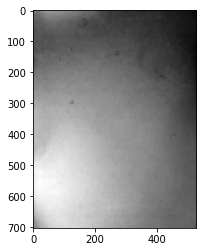

In [23]:
plt.imshow(img1, cmap="gray")

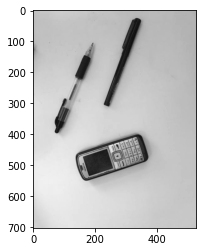

In [24]:
plt.imshow(img2, cmap="gray")

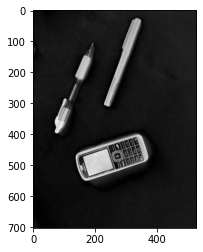

In [25]:
img = np.absolute(img1 - img2)
plt.imshow(img, cmap="gray")

In [28]:
img = downsize(img, scaling)

The image this process produces is often no very clear and has a lot of noise, so we use a median filter to remove some of that noise.

Our median filter works by setting each pixel in the image equal to the median of itself and the 8 pixels that are around it.

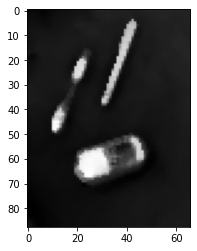

In [29]:
img = median_filter(img, filter_radius)
plt.imshow(img, cmap="gray")

Once we have done that, we use a threshold function to convert our grayscale image into a binary image. Occasionally, there are holes inside the objects, we set each pixel that is within a certain [euclidean distance](https://colab.research.google.com/drive/1SpOqGpoTWhjvkSycTPEC0tr46uUHBPYo#scrollTo=zdI_1WSZE3d0&line=5&uniqifier=1) of a white pixel to white as well.

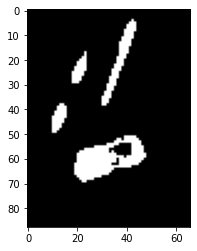

In [30]:
img = threshold_function(img, threshold)
plt.imshow(img, cmap="gray")

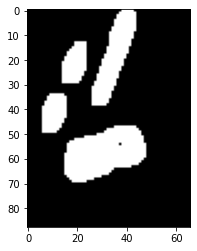

In [31]:
img = dilate(img, dilate_size)
plt.imshow(img, cmap="gray")

Once we have the binary image of the objects, we need to group the pixels into groups to separate the objects out. We could have juse created a fill tool for this, but we instead used some clustering techniques, which are more robust against noise in the image.

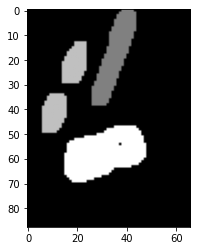

In [55]:
temp_image = np.zeros(img.shape)
for point in DBSCAN(img, dbscan_radius, dbscan_core_threshold)[0]:
  temp_image[point[0][0], point[0][1]] = point[1] + 1
plt.imshow(temp_image, cmap="gray")











Once we had the groups of pixels in each object we can then work out the centres of the groups, and then calculate the rotation the grabber needs to be at by taking the angle of the shortest line that can be drawn on each object that passes through the centre

In [72]:
get_rotations(img, DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1], centre_idx=centre_idx), DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1][centre_idx]

(76, [57.67225325884544, 30.47486033519553])

## Code

We don't have time to rewrite the entire code in this tutorial, so we'll only rewrite the clustering code and we'll explain eveything else verbally.

### Preprocessing

In [12]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time
from math import sin, cos, radians

In [13]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg

--2020-09-20 11:04:12--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9661 (9.4K) [image/jpeg]
Saving to: ‘input background.jpg.1’

input background.jp 100%[===================>]   9.43K  --.-KB/s    in 0s      

2020-09-20 11:04:12 (76.2 MB/s) - ‘input background.jpg.1’ saved [9661/9661]



In [14]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg

--2020-09-20 11:04:12--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21020 (21K) [image/jpeg]
Saving to: ‘input image.jpg.1’

input image.jpg.1   100%[===================>]  20.53K  --.-KB/s    in 0.007s  

2020-09-20 11:04:13 (2.87 MB/s) - ‘input image.jpg.1’ saved [21020/21020]



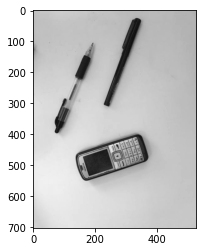

In [15]:
img1 = imread('input background.jpg')
if img1.ndim == 3:
    img1 = img1.mean(axis=2)

img2 = imread('input image.jpg')
if img2.ndim == 3:
    img2 = img2.mean(axis=2)
    
plt.imshow(img2, cmap='gray')

In [16]:
def median_filter(input_image, s):
    new_image = np.zeros((input_image.shape[0], input_image.shape[1]))
    for r in range(0, input_image.shape[1]):
        for c in range(0, input_image.shape[0]):
            values = []
            for ri in range(max(0, r - s), min(input_image.shape[1], r + s)):
                for ci in range(max(0, c - s), min(input_image.shape[0], c + s)):
                    values.append(input_image[ci, ri])
            values = sorted(values)
            new_image[c, r] = values[int(len(values) / 2)]

    return new_image

In [17]:
threshold_function = lambda image, threshold : np.asarray([[pixel>=threshold for pixel in row] for row in image])

In [18]:
downsize = lambda img, sf : np.array([[img[j, i] for i in range(0, len(img[0]), sf)] for j in range(0, len(img), sf)])

In [19]:
def dilate(image, radius):
  new_image = np.zeros(image.shape)
  image = np.pad(image, radius)
  for y in range(2, image.shape[0]-2):
    for x in range(2, image.shape[1]-2):
      coords = [[(y+j, x+i) for j in range(-radius, radius+1)] for i in range(-radius, radius+1)]
      total = np.asarray([[image[j] for j in i] for i in coords]).any()
      new_image[y-radius*2, x-radius*2] = total != 0
  return new_image

### Clusteting

#### K means Clustering

In [58]:
from random import randint, choices

In [59]:
image_dimensions = {"height": 200, "width": 200}
no_shapes = 3
shape_radius = 20
noise_level = 50 # larger -> less noise

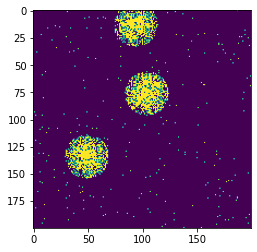

In [60]:
image = np.zeros((image_dimensions["height"], image_dimensions["width"]))

shapes = []
for i in range(no_shapes):
  centre = (randint(0, image_dimensions["width"]-1), randint(0, image_dimensions["height"]-1))
  shapes.append([centre, shape_radius])

for y in range(len(image)):
  for x in range(len(image[y])):
    for shape in shapes:
      distance = ((y - shape[0][1])**2 + (x - shape[0][0])**2)**0.5
      if distance <= shape[1] and randint(1, int(noise_level/(distance+1))) != 1 or randint(1, noise_level*10) == 1:
        image[y,x] = 1

imgplot = plt.imshow(image)

In [61]:
def k_means_max(image, k, epochs, n):

  outputs = []

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), 0])

  for i in range(n):

    centres = choices(points, k=k)

    for i in range(epochs):

      for point in points:
        distances = np.array([((point[0][0] - centre[0][0])**2 + (point[0][1] - centre[0][1])**2)**0.5 for centre in centres])
        group = np.argmin(distances)
        point[1] = group

      # find centres
      group_totals = [[0, 0] for i in range(k)]
      group_numbers = [0 for i in range(k)]
      for point in points:
        group_totals[point[1]][0] += point[0][0]
        group_totals[point[1]][1] += point[0][1]
        group_numbers[point[1]] += 1

      centres = []
      for group in range(len(group_totals)):
        try:
          centres.append([(group_totals[group][0]/group_numbers[group], (group_totals[group][1]/group_numbers[group])), group])
        except:
          centres.append([(0,0), group])

    loss = 0
    for point in points:
      distances = np.array([((point[0][0] - centre[0][0])**2 + (point[0][1] - centre[0][1])**2)**0.5 for centre in centres])
      loss += min(distances)

    outputs.append((points, centres, loss))

  best_loss = 1e10
  best_output = "error -> increase best loss"
  for output in outputs:
    if output[2] < best_loss:
      best_loss = output[2]
      best_output = output

  return best_output

No. objects: 3
Centres:  (109.06, 79.14), (93.42, 15.06), (49.77, 135.34)


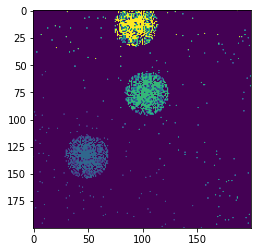

In [62]:
loss = []
for i in range(10):
  loss.append(k_means_max(image, i+1, 10, 5)[2])

derivatives = []
for i in range(len(loss)-1):
  derivatives.append(abs(loss[i]-loss[i+1]))

second_derivatives = []
for i in range(len(derivatives)-1):
  second_derivatives.append(abs(derivatives[i]-derivatives[i+1]))

third_derivatives = []
for i in range(len(second_derivatives)-1):
  third_derivatives.append(second_derivatives[i]-second_derivatives[i+1])

k = np.argmax(np.asarray(third_derivatives)) + 2

points, centres, loss = k_means_max(image, k, 15, 5)

temp_image = np.zeros((image_dimensions["height"], image_dimensions["width"]))
for point in points:
  temp_image[point[0][0], point[0][1]] = point[1] + 1
imgplot = plt.imshow(temp_image)

print(f"No. objects: {k}\nCentres: " + "".join([f", ({round(centre[0][1], 2)}, {round(centre[0][0], 2)})" for centre in centres])[1:])

#### DBSCAN

### complete code

In [54]:
def DBSCAN(image, radius, core_threshold):

  def RangeQuery(points, point1, radius):

    def dist(p1, p2):
      return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5

    neighbors = []
    for point2 in points:
        if dist(point1[0], point2[0]) <= radius:
            neighbors.append(point2)
    return neighbors

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), -1])

  cluster = 0
  for point in points:
    if point[1] == -1:
      neighbors = RangeQuery(points, point, radius)
      if len(neighbors) < core_threshold:
          point[1] = 0  # 0 -> noise
          continue
      cluster += 1
      point[1] = cluster
      neighbors.remove(point)
      for new_point in neighbors:
        if new_point[1] == 0:
          new_point[1] = cluster
        if new_point[1] != -1:
          continue
        new_point[1] = cluster
        new_neighbors = RangeQuery(points, new_point, radius)
        if len(neighbors) >= core_threshold:
          neighbors += new_neighbors

  centres = [[0,0] for i in range(cluster)]
  totals = [0 for i in range(cluster)]
  for point in points:
    if point[1] != 0:
      centres[point[1]-1][0] += point[0][0]
      centres[point[1]-1][1] += point[0][1]
      totals[point[1]-1] += 1

  for i in range(len(centres)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  return points, centres, loss

### Empty function

In [ ]:
def DBSCAN(image, radius, core_threshold):

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), -1])

  # DBSCAN CODE HERE

  centres = [[0,0] for i in range(cluster)]
  totals = [0 for i in range(cluster)]
  for point in points:
    if point[1] != 0:
      centres[point[1]-1][0] += point[0][0]
      centres[point[1]-1][1] += point[0][1]
      totals[point[1]-1] += 1

  for i in range(len(centres)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  return points, centres, loss

### Rotation finder

In [21]:
def get_rotations(image, centres, centre_idx=0, debug=False):

  def check_line_length(centre, angle, image):  # angle is from line to right

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))

    return dist(*coords)

  if debug:
    return [check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]
  return np.argmin(np.asarray([check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]))  # only one returned because we only do one rotation per time

In [22]:
def move_centres(image, centres):

  new_centres = [(1e5, 1e5) for i in centres]

  def dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append((y,x))

  for point in points:
    for i, centre in enumerate(centres):
      distance = dist(point, centre)
      if distance < new_centres[i][1]:
        new_centres[i] = (point, distance)

  return [i[0] for i in new_centres]

### Parameters and running the functions

In [52]:
def add_line(centre, angle, image):

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
        
      image[round(centre[0]+dy), round(centre[1]+dx)], image[round(centre[0]-dy), round(centre[1]-dx)] = 2, 2

    return image

In [27]:
scaling = 8
filter_radius = 2
threshold = 40
dbscan_radius = 5
dbscan_core_threshold = 3
dilate_size = 2
centre_idx = 2

Time elapsed: 1.42s
72


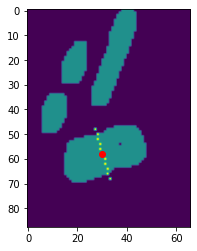

In [58]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
img = dilate(img, dilate_size)
centres = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1]
centres = move_centres(img, centres)
angle = get_rotations(img, centres, centre_idx=centre_idx)

print(f"Time elapsed: {round(time.clock() - start_time, 2)}s")
print(angle)
img = add_line(centres[centre_idx], radians(angle), img)
plt.imshow(img)
plt.scatter(centres[centre_idx][1], centres[centre_idx][0], c="r")
plt.show()

## What's next?

This project is pretty much finished, but here are some examples of possible extensions we might want to make if we continued:

1. I created a few loss graphs (below) for the functions to find which are the best parameters. We might want to adapt them to work with the current code to allow for better parameter tuning. Unfortunartely, they take a few hours each to generate.

2. We could consider writing a function to infer the background from the image. The current algorithm is really robust against noise, so not having a perfect background wouldn't be the end of the world. A simple example of what we could do for this would eb to simply set the background equal to the mode colour of the pixels in the image. This would assume the background is fairly flat, which may not be a very good assumption, though.

3. Now that we have a good source of predictions for where objects are in an image, we could use this to create a dataset for object detection that would be used to train a CNN (see below) to generate these outputs without the need for a background image

![DBSCAN loss graph](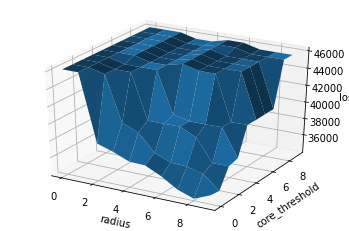%0A)

# Notes

## CNN

CNN stands for Convolutional Neural network, and is a very commonly used technique for image classifiction with neural networks. As with most deep learning methods, CNNs are very good at looking at raw images and extracting information that is often quite difficult to hard code an algorithm to understand. CNNs do, however, need a lot of training data to learn from, and, despite being faster than dense networks, are still a fairly slow method for object detection.

More info: https://en.wikipedia.org/wiki/Convolutional_neural_network

## Euclidean distance

Euclidian distance is the length of a straight line between two points. The euclidian distance between coordinates would be `((x1-x2)^2 + (y1-y2)^2)^0.5`

More info: https://en.wikipedia.org/wiki/Euclidean_distance